# Step 1: Data Ingestion
---
### Import Libraries 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

Using TensorFlow backend.


### Download Datasets
In this section, We will be downloading the datasets obtained from from the [Predictive Maintenance](https://www.kaggle.com/nafisur/dataset-for-predictive-maintenance). The dataset compiles data collected from 21 sensors for an aircraft engine. The three data files are:

    * `PM_train.txt`
    * `PM_test.txt`
    * `PM_truth.txt`


### Data Ingestion
In the following section, we ingest the training, test and ground truth datasets.

In [2]:
dataset_train=pd.read_csv('PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
dataset_test=pd.read_csv('PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names
#dataset_test.head()
print('Shape of Test dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Test dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
pm_truth=pd.read_csv('PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']
pm_truth['id']=pm_truth.index+1
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


# Step 2: Data Preparation and Processing
---
We next generate labels for the training data. Since the last observation is assumed to be a failure point, we can calculate the Remaining Useful Life (RUL) for every cycle in the data.

#### For help in understanding RUL following Resources were used :-
1) https://www.researchgate.net/publication/263507728_Overview_of_Remaining_Useful_Life_Prediction_Techniques_in_Through-life_Engineering_Services

2) https://www.equipmentappraisal.com/blog/understanding-remaining-useful-life-of-a-machine

3) https://medium.com/@RemiStudios/remaining-useful-life-in-predictive-maintenance-ffc91d7e4a97

In [5]:
# generate column max for test data
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


Using RUL, we can create a label indicating time to failure.

In [6]:
# run to failure
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [7]:
pm_truth.drop('more', axis=1, inplace=True)
dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left')
dataset_test['ttf']=dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)
dataset_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [8]:
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 27 columns):
id          20631 non-null int64
cycle       20631 non-null int64
setting1    20631 non-null float64
setting2    20631 non-null float64
setting3    20631 non-null float64
s1          20631 non-null float64
s2          20631 non-null float64
s3          20631 non-null float64
s4          20631 non-null float64
s5          20631 non-null float64
s6          20631 non-null float64
s7          20631 non-null float64
s8          20631 non-null float64
s9          20631 non-null float64
s10         20631 non-null float64
s11         20631 non-null float64
s12         20631 non-null float64
s13         20631 non-null float64
s14         20631 non-null float64
s15         20631 non-null float64
s16         20631 non-null float64
s17         20631 non-null int64
s18         20631 non-null int64
s19         20631 non-null float64
s20         20631 non-null float64
s21         20631 non-nu

In [10]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13096 entries, 0 to 13095
Data columns (total 27 columns):
id          13096 non-null int64
cycle       13096 non-null int64
setting1    13096 non-null float64
setting2    13096 non-null float64
setting3    13096 non-null float64
s1          13096 non-null float64
s2          13096 non-null float64
s3          13096 non-null float64
s4          13096 non-null float64
s5          13096 non-null float64
s6          13096 non-null float64
s7          13096 non-null float64
s8          13096 non-null float64
s9          13096 non-null float64
s10         13096 non-null float64
s11         13096 non-null float64
s12         13096 non-null float64
s13         13096 non-null float64
s14         13096 non-null float64
s15         13096 non-null float64
s16         13096 non-null float64
s17         13096 non-null int64
s18         13096 non-null int64
s19         13096 non-null float64
s20         13096 non-null float64
s21         13096 non-nu

In the following section, we create a new feature (label_bc) to indicate if the engine will fail within 30 days (RUL <=30).

In [11]:
df_train=dataset_train.copy()
df_test=dataset_test.copy()
period=30
df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [12]:
#Select the variables will be used for the LSTM Model
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

In the following section, we use a MinMaxScalaer to transform all variables by scaling each feature to a given range

In [13]:
sc=MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])

# Step 3: Model Building & Evaluation
---


#### LSTM Model Preperation

In [14]:
# function to generate sequence
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

In [15]:
# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [16]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [17]:
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['id']==id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)
# generate y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['id']==id], 50, seq_cols,'label_bc')) for id in df_train['id'].unique()))
print(y_train.shape)

(20531, 50, 24)
(20531,)


In [18]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['id']==id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['id']==id], 50, seq_cols,'label_bc')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 24)
(12996,)


#### LSTM Model Development

In [19]:
nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit the network
model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 19504 samples, validate on 1027 samples
Epoch 1/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.2018 - accuracy: 0.9208 - val_loss: 0.0629 - val_accuracy: 0.9737
Epoch 2/10
19504/19504 [==============================] - 18s 913us/step - loss: 0.0797 - accuracy: 0.9680 - val_loss: 0.0549 - val_accuracy: 0.9757
Epoch 3/10
19504/19504 [==============================] - 18s 932us/step - loss: 0.0704 - accuracy: 0.9694 - val_loss: 0.0469 - val_accuracy: 0.9825
Epoch 4/10
19504/19504 [==============================] - 18s 924us/step - loss: 0.0712 - accuracy: 0.9694 - val_loss: 0.0931 - val_accuracy: 0.9581


#### LSTM Model Evaluation

In [21]:
# training metrics
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

20531/20531 [==============================] - 6s 271us/step
Accurracy: 0.9672690033912659


In [22]:
y_pred=model.predict_classes(X_test)
print('Accuracy of model on test data: ',accuracy_score(y_test,y_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))

Accuracy of model on test data:  0.9878424130501693
Confusion Matrix: 
 [[12663     1]
 [  157   175]]


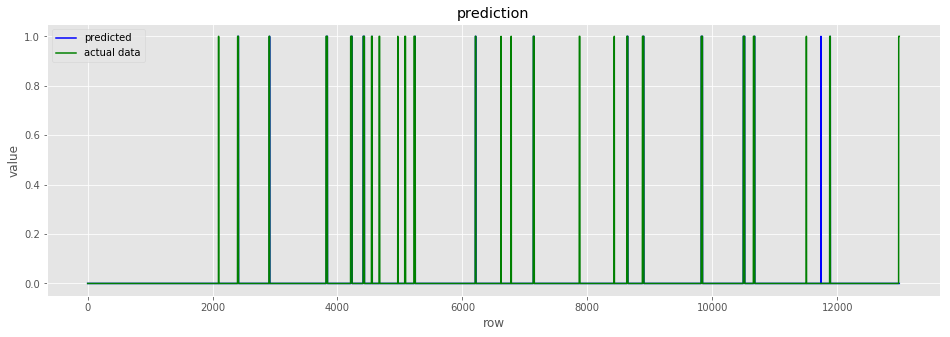

In [30]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(16, 5))
plt.plot(y_pred, color="blue")
plt.plot(y_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
#fig_verify.savefig("model_verify.png")

#### Model Prediction 

In [23]:
def prob_failure(machine_id):
    machine_df=df_test[df_test.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

#### Rule-Based Function

In [24]:
!pip install https://github.com/buguroo/pyknow/archive/v1.7.0.tar.gz

  Stored in directory: C:\Users\Vishwam\AppData\Local\Temp\pip-ephem-wheel-cache-846dsdgt\wheels\60\0d\f3\ec32e587d51ab5454ab6fb005b9ec929e19c52bf06725a6786
  Stored in directory: C:\Users\Vishwam\AppData\Local\pip\Cache\wheels\6c\6c\e9\534386165bd12cf1885582c75eb6d0ffcb321b65c23fe0f834
Successfully built pyknow frozendict


In [25]:
from random import choice
from pyknow import *
from pyknow import P

class Machine_Failure(Fact):
    """Info about the machine maintenace actions."""
    pass

# KnowledgeEngine 
# You ES will subclass KnowledgeEngine
# 1. Decorate methods to define rules of the ES
# 2. Instantiate
# 3. Reset system (reset() method) : prep for execution
# 4. declare input facts (delare() method)
# 5. run the engine (run method)
class Maintenance_Status(KnowledgeEngine):
    # The Rule is callable
    # Will match with every instace of 'probability' Fact

    @Rule(Machine_Failure(prop=P(lambda x: x >= 0)& P(lambda x: x < 40)))
    def normal_status(self):
        print("No Action Required")

    @Rule(Machine_Failure(prop=P(lambda x: x >= 40)& P(lambda x: x < 50)))
    def action_1(self):
        print("Send a team to analyze machine and predict maintenance requirements")
    
    @Rule(Machine_Failure(prop=P(lambda x: x >= 50)& P(lambda x: x < 60)))
    def action_2(self):
        print("Create work order and prepare for maintenance request")

    @Rule(Machine_Failure(prop=P(lambda x: x >= 60)& P(lambda x: x < 80)))
    def naction_3(self):
        print("Schedule and dispatch work and resources") # RHS

    @Rule(Machine_Failure(prop=P(lambda x: x >= 80)& P(lambda x: x <= 100)))
    def action_4(self):
        print("Excute maintenace") 

# Step 4: Prediction
---


#### Check probability of failure within next 30 days

In [26]:
machine_id=81
prob=prob_failure(machine_id)
print('Probability that machine will fail within 30 days: ',prob)

Probability that machine will fail within 30 days:  98.88634


#### Check maintenance action required

In [27]:
engine = Maintenance_Status()
engine.reset()
engine.get_rules()
engine.declare(Machine_Failure(prop=prob))
engine.run()

Excute maintenace


In [28]:
for machine_id in range(100):
    print("Probability that machine-%d will fail within 30 days: %.5f %% \n" %(machine_id + 1, 
                                                                            prob_failure(machine_id + 1)))

Probability that machine-1 will fail within 30 days: 0.01888 % 

Probability that machine-2 will fail within 30 days: 0.05686 % 

Probability that machine-3 will fail within 30 days: 0.55045 % 

Probability that machine-4 will fail within 30 days: 0.06895 % 

Probability that machine-5 will fail within 30 days: 0.09411 % 

Probability that machine-6 will fail within 30 days: 0.05710 % 

Probability that machine-7 will fail within 30 days: 0.02866 % 

Probability that machine-8 will fail within 30 days: 0.12163 % 

Probability that machine-9 will fail within 30 days: 0.05379 % 

Probability that machine-10 will fail within 30 days: 0.05176 % 

Probability that machine-11 will fail within 30 days: 0.07372 % 

Probability that machine-12 will fail within 30 days: 0.03595 % 

Probability that machine-13 will fail within 30 days: 0.05005 % 

Probability that machine-14 will fail within 30 days: 0.06576 % 

Probability that machine-15 will fail within 30 days: 0.02561 % 

Probability that ma